# Building a simple recurrent network using the n-back task as an example.

This notebook works through building a simple recurrent network in Keras/Tensorflow, using the classic _n-back_ task as an example. In N-back, the participant views a series of symbols (e.g. numbers or letters) and must press a button if the currently-viewed symbol matches the one viewed _n_ steps previously. For instance, in a 2-back letter task, the participant views a sequence of letters and, as each letter appears, decides whether it is identical to the letter seen 2 steps ago. If yes she presses the button; if no she does not. 

The model for this task thus should take in a one-hot representation of the currently-viewed symbol (ie one unit standing for each possible symbol in the sequence) and output a single unit that is active when the current item matches the n-back target and inactive otherwise. To do this the model must learn to keep an internal representation of the previously-viewed _n_ items _and_ the order in which they were viewed. We will compare the ability of models using standard simple recurrence vs LSTM recurrence to solve this problem.



## Imports

In [1]:
# Import basic Python modules for data science
import numpy as np  #Provides numpy arrays, functions, and methods
import matplotlib.pyplot as plt  #Provides plotting tools

#Import tensorflow and some commonly-used classes and functions
import tensorflow as tf  #Tensorflow library
from tensorflow.keras.utils import to_categorical #Generates one-hot vectors from list of single integers
from tensorflow.keras.layers import Input, Dense, LSTM, SimpleRNN #Layer types we will need
from tensorflow.keras.models import Model #Generic model type


2024-03-07 09:58:51.841497: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 09:58:52.063795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 09:58:52.063829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 09:58:52.121491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 09:58:52.200808: I tensorflow/core/platform/cpu_feature_guar

# Create the environment
In standard feed-forward networks, input and output patterns took the form of _matrices_, that is, two-dimensional numpy arrays. The first dimension (rows) encoded input and output patterns for different items, while the second dimension (columns) indicated the different input/output units in the model. For recurrent models, each training/testing example is a _sequence_ of inputs. We still want to train and test on many different examples (one dimension of the array), and each step of the sequence for an example still has to specify activation patterns over some number of input/output units (another dimension), but each example now include multiple steps in the sequence--so we need a third dimension. So for recurrent networks, input and output patterns are encoded in a _three-dimensional_ numpy array.

In Tensorflow recurrent models, the first dimension of the array typically indicates the different examples, the second dimension typically indicates the different steps of the sequence, and the third indicates the different units. So if you want a model that has 5 input units and processes sequences with a total of 20 steps, and you have created 100 such sequences, your input array would have shape (100,20,5).

**Note:** A _tensor_ is similar to a multi-dimensional array, with a few sort of technical differences. For the purposes of this class, we can use _tensor_ and _array_ interchangeably. _Tensorflow_ is so-named because the network is essentially taking a tensor (array) of input patterns and passing these through a series of transformations to generate other tensors (arrays, hidden patterns, internal representations), evenutally producing a tensor of output activations.

**Warning:** Technically tensors and numpy arrays are different kinds of data structures in Python, with different methods attached, etc. In many cases they can be used interchangeably, but sometimes not. A common point of frustration arises when a function that is expecting a tensor instead gets a numpy array or vice versa. Be aware that Tensorflow can take numpy arrays as inputs, and that the _predict_ method on a model object will generate numpy arrays as outputs, and you should be fine.

## Define functions to automatically generate n-back inputs and outputs
In previous labs we either hand-coded patterns or read them in from a .csv file. Another common approach is to write a function to automatically generate input and output patterns. This is ideal for the n-back task, where the inputs should just be a random sequence of symbols (which can be encoded as a sequence of one-hot vectors) and the outputs should be a sequence of zeroes and ones.

The following code block creates a function that will generate a numpy array containing sequences of inputs and targets with the following parameters:
- _n_: The distance at which matches should be judged (ie the n in n-back)
- _numitems_: The total number of symbols in the experiment
- _seqlength_: The length of each sequence in training and testing data
- _numpats_: The number of sequences to produce
Have a look through the code and make sure you understand what it is doing.

In [9]:
#Function to create input and output arrays for the n-back task

def make_patterns(n, numitems = 5, seqlength=20, numpats=100):
    #x = np.zeros([numpats,seqlength, numitems]) #Create input array filled with zeros
    #y = np.zeros([numpats, seqlength,1])        #Create output array gilled with zeros
    
    offset = seqlength - n #This is the point at which model can start making decisions
    
    x = np.random.randint(0,numitems,size=(numpats,seqlength)) #Generate 2D array of random integers between 0 and numitems - 1
    y = np.zeros((numpats,offset))                             #Generate 2D array of zeros
    m = x[:,0:offset] == x[:,n:seqlength]                      #Compares n-back values in x adn returns True for matches, False otherwise
    y[m] = 1                                                   #Puts target value of 1 for matches in output patterns
    y= np.concatenate([np.zeros((numpats,n)), y], axis=1)      #Adds zero values for first n items in sequence
    
    x = to_categorical(x)                                      #Converts integers to one-hot array
    
    
    return x, y
     
        

Use function to generate training and testing sets:

In [10]:
n = 2 #Matching distance
nitems = 5 #size of vocabulary
slength = 20 #Length of each sequence
npats = 100 #Number of sequences

[xtrn, ytrn] = make_patterns(n,nitems,slength,npats)
[xtst, ytst] = make_patterns(n,nitems,slength,npats)
xtrn.shape

(100, 20, 5)

In [13]:
xtrn[1,:,:]

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

## Build network

For feed-forward models in prior lab, we created an input layer that had a _shape_ specified as ```shape = (number_of_units,)```. For recurrent models, Tensorflow assumes the first dimension of the array is the _batch dimension_, that is, the dimension that indexes over different sequences. Because this is so, you do not have to include that dimension in the shape of the input layer--instead, when you create the layer, you specify ```shape = (number_of_steps_in_seq, num_of_input_units)```.

From the parameters set in the code block above, our input patterns have _slength_ steps in each sequence and _nitems_ possible symbols at each step, so the input shape should be (_slength_, _nitems_).

For the hiden layer we just need to specify the number of hidden units; Tensorflow will figure out the number of steps in the sequence on its own. Same for the output activation. 

**Note:** To have the hidden layer propagate activation to the output unit on every time-step, we need to set _return_\__sequences_ to **True.** Otherwise the model will take the whole sequence of input and output just a single value at the end.

In [14]:
#Build model

initem = Input(shape=(slength,nitems)) #Input layer
hidden = SimpleRNN(units=32, activation='sigmoid', return_sequences=True)(initem) #Recurrent hidden layer
outact = Dense(1, activation='sigmoid')(hidden)   #Output layer

srn = Model(inputs=initem, outputs=outact)  #Create the model object

srn.summary()

2024-03-07 10:44:35.235300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 10:44:35.347332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 10:44:35.347372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 10:44:35.350620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 10:44:35.350651: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 5)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 32)            1216      
                                                                 
 dense (Dense)               (None, 20, 1)             33        
                                                                 
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
#Compile model
srn.compile(optimizer='RMSProp', loss='mean_squared_error')

In [16]:
#Fit model
H = srn.fit(x=xtrn, y=ytrn, batch_size = 10, epochs = 1000)

Epoch 1/1000


2024-03-07 10:45:05.731923: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6977649480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 10:45:05.731979: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-07 10:45:05.750733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-07 10:45:06.196638: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709829906.245100   17277 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 4s 18ms/step - loss: 0.1604
Epoch 2/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1530
Epoch 3/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.1519
Epoch 4/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1515
Epoch 5/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.1513
Epoch 6/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1511
Epoch 7/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1509
Epoch 8/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.1507
Epoch 9/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.1505
Epoch 10/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1503
Epoch 11/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1501
Epoch 12/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1500
Epoch 13/1000
10/10 [=====

Epoch 196/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0401
Epoch 197/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0402
Epoch 198/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0399
Epoch 199/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0399
Epoch 200/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0400
Epoch 201/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0397
Epoch 202/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0392
Epoch 203/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0394
Epoch 204/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0395
Epoch 205/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0397
Epoch 206/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0394
Epoch 207/1000
10/10 [==============================] - 1s 57ms/step - loss:

10/10 [==============================] - 1s 62ms/step - loss: 0.0316
Epoch 294/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0317
Epoch 295/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.0314
Epoch 296/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0313
Epoch 297/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0314
Epoch 298/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0314
Epoch 299/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0312
Epoch 300/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0308
Epoch 301/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0310
Epoch 302/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0311
Epoch 303/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0306
Epoch 304/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.0305
Epoch 3

10/10 [==============================] - 1s 60ms/step - loss: 0.0186
Epoch 391/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.0185
Epoch 392/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0181
Epoch 393/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0182
Epoch 394/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0182
Epoch 395/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0176
Epoch 396/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0175
Epoch 397/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0173: 0s - los
Epoch 398/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0176
Epoch 399/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0169
Epoch 400/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0166
Epoch 401/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.01

10/10 [==============================] - 1s 58ms/step - loss: 0.0061
Epoch 488/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.0059
Epoch 489/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0061
Epoch 490/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0058
Epoch 491/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0059
Epoch 492/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0056
Epoch 493/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.0056
Epoch 494/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0057
Epoch 495/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0055
Epoch 496/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.0053
Epoch 497/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0054
Epoch 498/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0055
Epoch 4

10/10 [==============================] - 1s 60ms/step - loss: 0.0016
Epoch 585/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0016
Epoch 586/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0015
Epoch 587/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0015
Epoch 588/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0015
Epoch 589/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0015
Epoch 590/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0015
Epoch 591/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0013
Epoch 592/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.0014
Epoch 593/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0014
Epoch 594/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0013
Epoch 595/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0014
Epoch 5

10/10 [==============================] - 0s 33ms/step - loss: 3.3267e-04
Epoch 679/1000
10/10 [==============================] - 0s 35ms/step - loss: 3.0350e-04
Epoch 680/1000
10/10 [==============================] - 0s 35ms/step - loss: 3.5543e-04
Epoch 681/1000
10/10 [==============================] - 0s 35ms/step - loss: 3.1363e-04
Epoch 682/1000
10/10 [==============================] - 0s 33ms/step - loss: 3.0261e-04
Epoch 683/1000
10/10 [==============================] - 0s 37ms/step - loss: 2.9355e-04
Epoch 684/1000
10/10 [==============================] - 0s 34ms/step - loss: 3.2219e-04
Epoch 685/1000
10/10 [==============================] - 0s 34ms/step - loss: 2.7338e-04
Epoch 686/1000
10/10 [==============================] - 0s 46ms/step - loss: 2.7466e-04
Epoch 687/1000
10/10 [==============================] - 1s 60ms/step - loss: 2.8880e-04
Epoch 688/1000
10/10 [==============================] - 1s 60ms/step - loss: 2.6712e-04
Epoch 689/1000
10/10 [=========================

10/10 [==============================] - 1s 58ms/step - loss: 6.8895e-05
Epoch 772/1000
10/10 [==============================] - 1s 58ms/step - loss: 6.3447e-05
Epoch 773/1000
10/10 [==============================] - 1s 61ms/step - loss: 5.6618e-05
Epoch 774/1000
10/10 [==============================] - 1s 58ms/step - loss: 7.3525e-05
Epoch 775/1000
10/10 [==============================] - 1s 55ms/step - loss: 5.2878e-05
Epoch 776/1000
10/10 [==============================] - 1s 57ms/step - loss: 5.8849e-05
Epoch 777/1000
10/10 [==============================] - 1s 58ms/step - loss: 6.1269e-05
Epoch 778/1000
10/10 [==============================] - 1s 58ms/step - loss: 5.7265e-05
Epoch 779/1000
10/10 [==============================] - 1s 56ms/step - loss: 5.5126e-05
Epoch 780/1000
10/10 [==============================] - 1s 60ms/step - loss: 5.0346e-05
Epoch 781/1000
10/10 [==============================] - 1s 60ms/step - loss: 5.0863e-05
Epoch 782/1000
10/10 [=========================

10/10 [==============================] - 1s 58ms/step - loss: 1.0098e-05
Epoch 865/1000
10/10 [==============================] - 1s 64ms/step - loss: 1.0846e-05
Epoch 866/1000
10/10 [==============================] - 1s 59ms/step - loss: 1.0404e-05
Epoch 867/1000
10/10 [==============================] - 1s 63ms/step - loss: 1.0547e-05
Epoch 868/1000
10/10 [==============================] - 1s 59ms/step - loss: 1.3784e-05
Epoch 869/1000
10/10 [==============================] - 1s 56ms/step - loss: 1.1737e-05
Epoch 870/1000
10/10 [==============================] - 0s 40ms/step - loss: 9.1740e-06
Epoch 871/1000
10/10 [==============================] - 1s 57ms/step - loss: 1.0965e-05
Epoch 872/1000
10/10 [==============================] - 1s 58ms/step - loss: 9.7173e-06
Epoch 873/1000
10/10 [==============================] - 1s 62ms/step - loss: 9.0796e-06
Epoch 874/1000
10/10 [==============================] - 1s 58ms/step - loss: 8.6993e-06
Epoch 875/1000
10/10 [=========================

10/10 [==============================] - 1s 59ms/step - loss: 2.9432e-06
Epoch 958/1000
10/10 [==============================] - 1s 58ms/step - loss: 2.2003e-06
Epoch 959/1000
10/10 [==============================] - 1s 62ms/step - loss: 2.0093e-06
Epoch 960/1000
10/10 [==============================] - 1s 60ms/step - loss: 2.4164e-06
Epoch 961/1000
10/10 [==============================] - 1s 60ms/step - loss: 2.6182e-06
Epoch 962/1000
10/10 [==============================] - 1s 62ms/step - loss: 1.9693e-06
Epoch 963/1000
10/10 [==============================] - 1s 57ms/step - loss: 2.5093e-06
Epoch 964/1000
10/10 [==============================] - 1s 60ms/step - loss: 1.8855e-06
Epoch 965/1000
10/10 [==============================] - 1s 50ms/step - loss: 3.1162e-06: 0s - loss: 1.76
Epoch 966/1000
10/10 [==============================] - 0s 32ms/step - loss: 1.7800e-06
Epoch 967/1000
10/10 [==============================] - 0s 35ms/step - loss: 1.7844e-06
Epoch 968/1000
10/10 [========

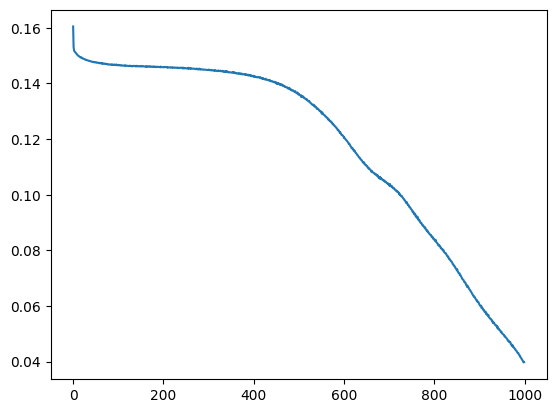

In [18]:
trnloss = H.history['loss']
plt.plot(trnloss)

In [19]:
#Generate output activations for test set
p = srn.predict(xtst)

4/4 [==============================] - 0s 6ms/step


In [22]:
print(np.round(p[0,:,0], decimals = 2))

[0.   0.01 0.18 0.67 0.42 0.03 0.61 0.   0.11 0.   0.02 0.55 0.01 0.
 0.01 0.   0.46 0.73 0.01 0.03]


In [68]:
print(ytst[0,:])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]


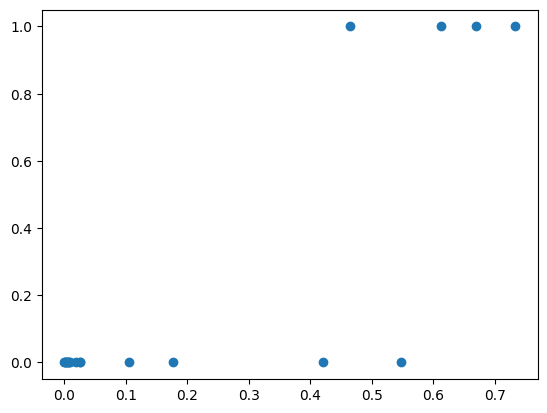

In [23]:
plt.scatter(p[0,:,0], ytst[0,:])

## LSTM variant

Let's build a similar model but using a _long-short-term-memory_ (LSTM) layer for the recurrence. Long short term memory is more complicated than simple recurrence, but is meant to enable learning of longer-range temporal dependencies. Constructing, training, and testing the model is identical to simple RNN above, just swapping out the type of layer specified for the recurrence.

In [25]:
inlstm = Input(shape=(slength,nitems)) #Input tensor
hidlstm = LSTM(units=32, activation='sigmoid', return_sequences=True)(inlstm)
outlstm = Dense(1, activation='sigmoid')(hidlstm)

lstm = Model(inputs=inlstm, outputs=outlstm)

lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 5)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            4864      
                                                                 
 dense_2 (Dense)             (None, 20, 1)             33        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
#Compile model
lstm.compile(optimizer='RMSProp', loss='mean_squared_error')

In [27]:
H = lstm.fit(x=xtrn, y=ytrn, batch_size = 10, epochs = 2000)

Epoch 1/2000
10/10 [==============================] - 1s 26ms/step - loss: 0.1894
Epoch 2/2000
10/10 [==============================] - 0s 26ms/step - loss: 0.1677
Epoch 3/2000
10/10 [==============================] - 0s 28ms/step - loss: 0.1607
Epoch 4/2000
10/10 [==============================] - 0s 27ms/step - loss: 0.1580
Epoch 5/2000
10/10 [==============================] - 0s 26ms/step - loss: 0.1569
Epoch 6/2000
10/10 [==============================] - 0s 26ms/step - loss: 0.1562
Epoch 7/2000
10/10 [==============================] - 0s 26ms/step - loss: 0.1556
Epoch 8/2000
10/10 [==============================] - 0s 27ms/step - loss: 0.1552
Epoch 9/2000
10/10 [==============================] - 0s 27ms/step - loss: 0.1547
Epoch 10/2000
10/10 [==============================] - 0s 27ms/step - loss: 0.1543
Epoch 11/2000
10/10 [==============================] - 0s 27ms/step - loss: 0.1539
Epoch 12/2000
10/10 [==============================] - 0s 27ms/step - loss: 0.1535
Epoch 13/2000

10/10 [==============================] - 0s 42ms/step - loss: 0.0622
Epoch 197/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0620
Epoch 198/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.0617
Epoch 199/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0614
Epoch 200/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0611
Epoch 201/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0609
Epoch 202/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0606
Epoch 203/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0606
Epoch 204/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0604
Epoch 205/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0599
Epoch 206/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0598
Epoch 207/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0596
Epoch 2

10/10 [==============================] - 0s 41ms/step - loss: 0.0412
Epoch 294/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0409
Epoch 295/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0408
Epoch 296/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0404
Epoch 297/1000
10/10 [==============================] - 0s 44ms/step - loss: 0.0404
Epoch 298/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0402
Epoch 299/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0401
Epoch 300/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0396
Epoch 301/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0397
Epoch 302/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0395
Epoch 303/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0391
Epoch 304/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0391
Epoch 3

10/10 [==============================] - 0s 43ms/step - loss: 0.0244
Epoch 391/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0243
Epoch 392/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0244
Epoch 393/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0242
Epoch 394/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0240
Epoch 395/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0238
Epoch 396/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0236
Epoch 397/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0237
Epoch 398/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0235
Epoch 399/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0232
Epoch 400/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0231
Epoch 401/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0229
Epoch 4

10/10 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 488/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0124
Epoch 489/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0122
Epoch 490/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0119
Epoch 491/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0120
Epoch 492/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0117
Epoch 493/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0118
Epoch 494/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0116
Epoch 495/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0116
Epoch 496/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0113
Epoch 497/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0115
Epoch 498/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0112
Epoch 4

10/10 [==============================] - 0s 41ms/step - loss: 0.0050
Epoch 585/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0049
Epoch 586/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0049
Epoch 587/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.0048
Epoch 588/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0048
Epoch 589/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0048
Epoch 590/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0047
Epoch 591/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0046
Epoch 592/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0046
Epoch 593/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0045
Epoch 594/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0045
Epoch 595/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0044
Epoch 5

10/10 [==============================] - 0s 41ms/step - loss: 0.0016
Epoch 682/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0016
Epoch 683/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0016
Epoch 684/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0016
Epoch 685/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0016
Epoch 686/1000
10/10 [==============================] - 0s 42ms/step - loss: 0.0015
Epoch 687/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0015
Epoch 688/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0014
Epoch 689/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0016
Epoch 690/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0014
Epoch 691/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0014
Epoch 692/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0014
Epoch 6

10/10 [==============================] - 0s 42ms/step - loss: 4.2624e-04
Epoch 776/1000
10/10 [==============================] - 0s 41ms/step - loss: 4.7173e-04
Epoch 777/1000
10/10 [==============================] - 0s 42ms/step - loss: 4.1630e-04
Epoch 778/1000
10/10 [==============================] - 0s 41ms/step - loss: 4.8080e-04
Epoch 779/1000
10/10 [==============================] - 0s 38ms/step - loss: 4.0620e-04
Epoch 780/1000
10/10 [==============================] - 0s 41ms/step - loss: 4.5713e-04
Epoch 781/1000
10/10 [==============================] - 0s 40ms/step - loss: 4.3393e-04
Epoch 782/1000
10/10 [==============================] - 0s 39ms/step - loss: 3.9405e-04
Epoch 783/1000
10/10 [==============================] - 0s 44ms/step - loss: 3.9028e-04
Epoch 784/1000
10/10 [==============================] - 0s 45ms/step - loss: 4.0513e-04
Epoch 785/1000
10/10 [==============================] - 0s 39ms/step - loss: 4.1991e-04
Epoch 786/1000
10/10 [=========================

10/10 [==============================] - 0s 41ms/step - loss: 1.1643e-04
Epoch 869/1000
10/10 [==============================] - 0s 40ms/step - loss: 1.1964e-04
Epoch 870/1000
10/10 [==============================] - 0s 38ms/step - loss: 1.1693e-04
Epoch 871/1000
10/10 [==============================] - 0s 45ms/step - loss: 1.1695e-04
Epoch 872/1000
10/10 [==============================] - 0s 46ms/step - loss: 1.1253e-04
Epoch 873/1000
10/10 [==============================] - 1s 59ms/step - loss: 1.1546e-04
Epoch 874/1000
10/10 [==============================] - 0s 48ms/step - loss: 1.1789e-04
Epoch 875/1000
10/10 [==============================] - 0s 45ms/step - loss: 1.0143e-04
Epoch 876/1000
10/10 [==============================] - 0s 38ms/step - loss: 1.0994e-04
Epoch 877/1000
10/10 [==============================] - 0s 39ms/step - loss: 1.1108e-04
Epoch 878/1000
10/10 [==============================] - 0s 42ms/step - loss: 1.0794e-04
Epoch 879/1000
10/10 [=========================

10/10 [==============================] - 0s 42ms/step - loss: 4.2768e-05
Epoch 962/1000
10/10 [==============================] - 0s 41ms/step - loss: 2.7236e-05
Epoch 963/1000
10/10 [==============================] - 0s 39ms/step - loss: 2.7302e-05
Epoch 964/1000
10/10 [==============================] - 0s 40ms/step - loss: 3.4849e-05
Epoch 965/1000
10/10 [==============================] - 0s 38ms/step - loss: 2.7629e-05
Epoch 966/1000
10/10 [==============================] - 0s 40ms/step - loss: 2.7339e-05
Epoch 967/1000
10/10 [==============================] - 0s 43ms/step - loss: 3.3232e-05
Epoch 968/1000
10/10 [==============================] - 0s 41ms/step - loss: 2.6194e-05
Epoch 969/1000
10/10 [==============================] - 0s 47ms/step - loss: 2.6426e-05
Epoch 970/1000
10/10 [==============================] - 0s 37ms/step - loss: 3.1248e-05
Epoch 971/1000
10/10 [==============================] - 0s 34ms/step - loss: 2.4729e-05
Epoch 972/1000
10/10 [=========================

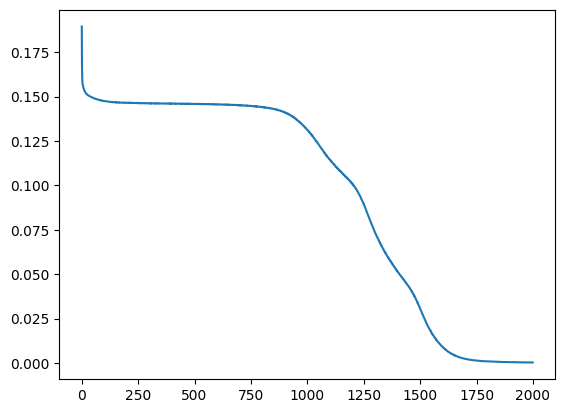

In [28]:
plt.plot(H.history['loss'])

4/4 [==============================] - 0s 8ms/step


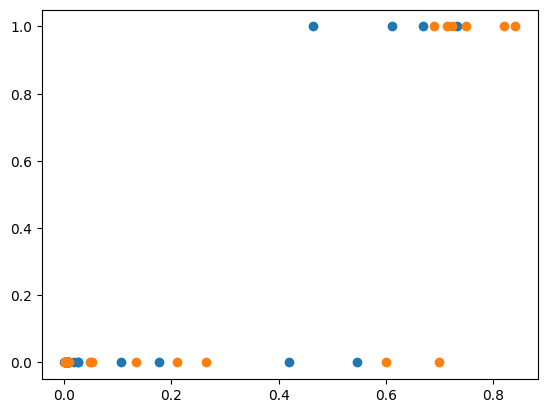

In [29]:
p = srn.predict(xtst)
plt.scatter(p[0,:,0], ytst[0,:])
plt.scatter(p[1,:,0], ytst[1,:])
